In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import Holt




In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\dell\OneDrive\Desktop\Excle_assignment\assignment_news\Timeseries\exchange_rate.csv", parse_dates=['date'])

# Set date as index
df.set_index('date', inplace=True)

# Show first rows
print(df.head())


            Ex_rate
date               
1990-01-01   0.7855
1990-02-01   0.7818
1990-03-01   0.7867
1990-04-01   0.7860
1990-05-01   0.7849


In [3]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None
           Ex_rate
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


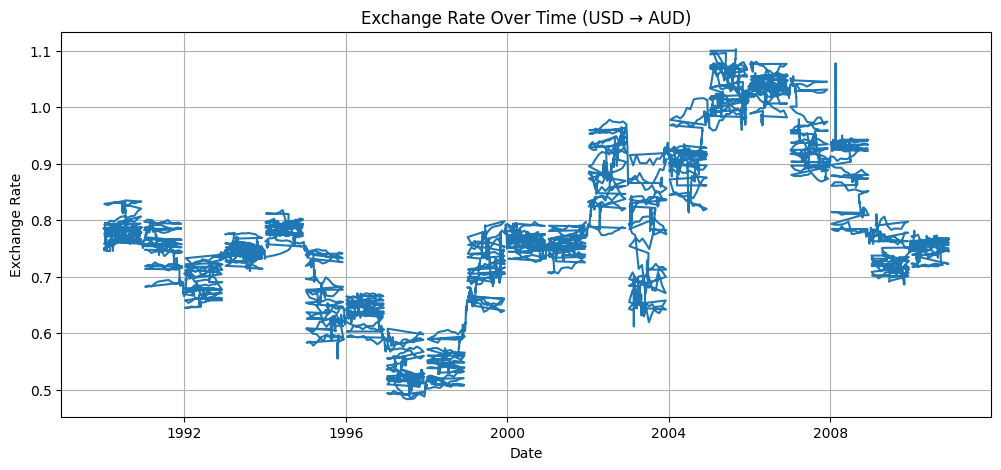

In [4]:
# Plot Time Series
plt.figure(figsize=(12,5))
plt.plot(df['Ex_rate'])
plt.title("Exchange Rate Over Time (USD → AUD)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.show()



Data Preprocessing

In [5]:
# Check Missing Values
print(df.isnull().sum())



Ex_rate    0
dtype: int64


In [6]:
# Remove Outliers
Q1 = df['Ex_rate'].quantile(0.25)
Q3 = df['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['Ex_rate'] >= lower) & (df['Ex_rate'] <= upper)]


Model Building - ARIMA

<Figure size 1000x400 with 0 Axes>

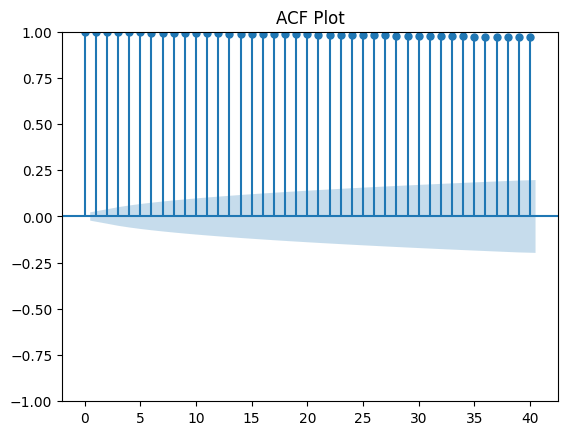

In [7]:
# ACF Plot (for q)
plt.figure(figsize=(10,4))
plot_acf(df['Ex_rate'], lags=40)
plt.title("ACF Plot")
plt.show()




<Figure size 1000x400 with 0 Axes>

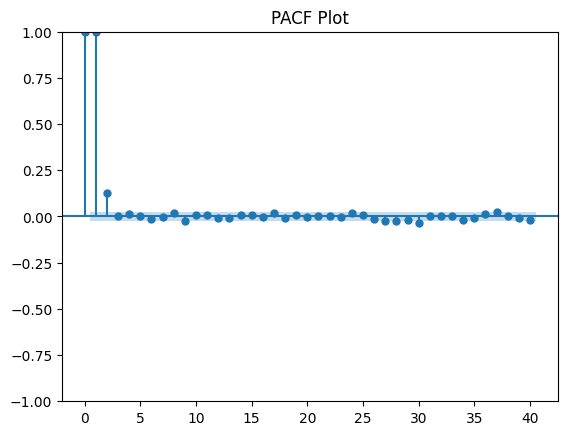

In [8]:
# PACF Plot (for p)
plt.figure(figsize=(10,4))
plot_pacf(df['Ex_rate'], lags=40, method='ywm')
plt.title("PACF Plot")
plt.show()




In [9]:
# ARIMA Model

model = sm.tsa.ARIMA(df['Ex_rate'], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())



C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._ini

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 26 Nov 2025   AIC                         -56102.322
Time:                        21:44:47   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

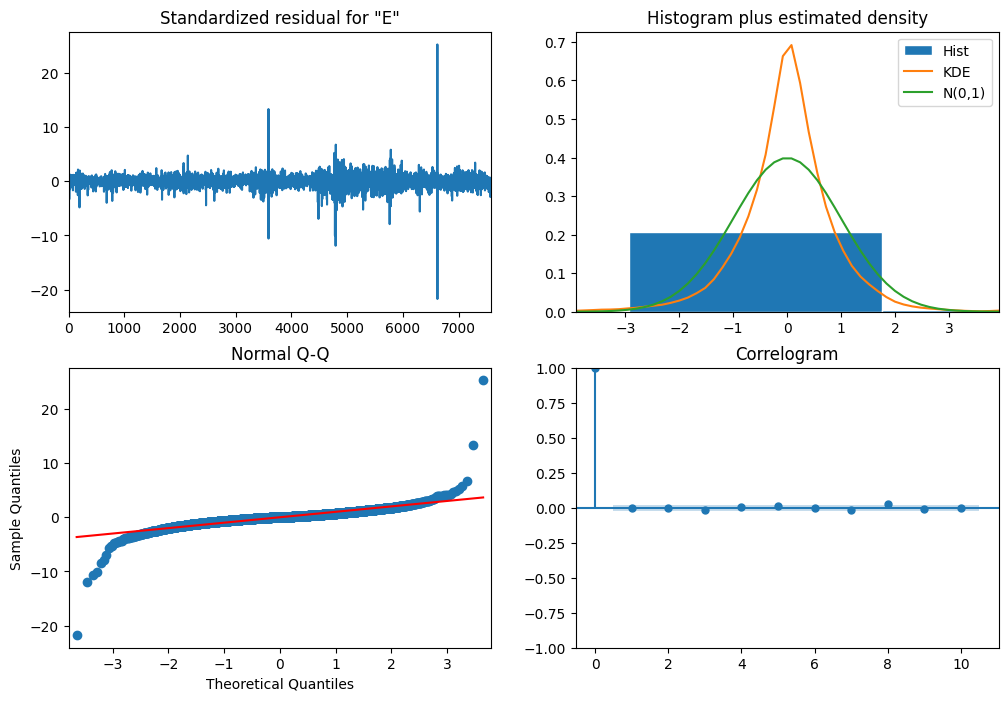

In [10]:
# Diagnostics (Check Residuals)

model_fit.plot_diagnostics(figsize=(12,8))
plt.show()


In [11]:
# Forecasting
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)
print(forecast)




C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


7588    0.720826
7589    0.720826
7590    0.720826
7591    0.720826
7592    0.720826
7593    0.720826
7594    0.720826
7595    0.720826
7596    0.720826
7597    0.720826
7598    0.720826
7599    0.720826
Name: predicted_mean, dtype: float64


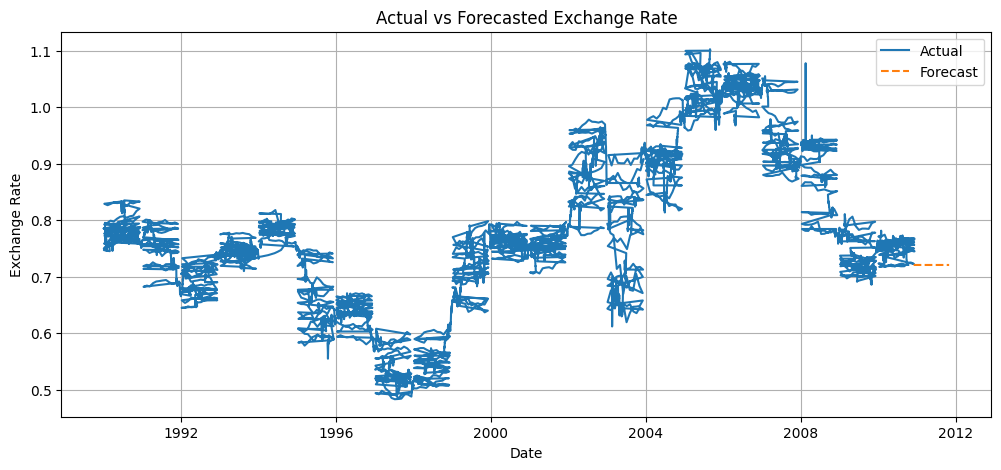

In [12]:
# Visualize Actual vs Forecast
plt.figure(figsize=(12,5))

# Plot original series
plt.plot(df['Ex_rate'], label='Actual')

# Create future index for forecast values
future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:]

plt.plot(future_dates, forecast, label='Forecast', linestyle='--')

plt.title('Actual vs Forecasted Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()




Model Building - Exponential Smoothing

In [13]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(df['Ex_rate']).fit()

ses_model




C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
# Holt’s Linear Trend Model
holt_model = ExponentialSmoothing(
    df['Ex_rate'],
    trend='add',
    seasonal=None
).fit()




C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Holt-Winters
hw_model = ExponentialSmoothing(
    df['Ex_rate'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()




C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
# Parameter Optimization
print(holt_model.params)
print("AIC:", holt_model.aic)




{'smoothing_level': 0.8698393420454087, 'smoothing_trend': 0.0, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 0.785109931916386, 'initial_trend': -8.4744950114707e-06, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
AIC: -77641.00965078664


In [17]:
# Fit + Forecast
forecast_steps = 12
holt_forecast = holt_model.forecast(forecast_steps)
print(holt_forecast)




7588    0.720852
7589    0.720843
7590    0.720835
7591    0.720826
7592    0.720818
7593    0.720809
7594    0.720801
7595    0.720792
7596    0.720784
7597    0.720775
7598    0.720767
7599    0.720758
dtype: float64


C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


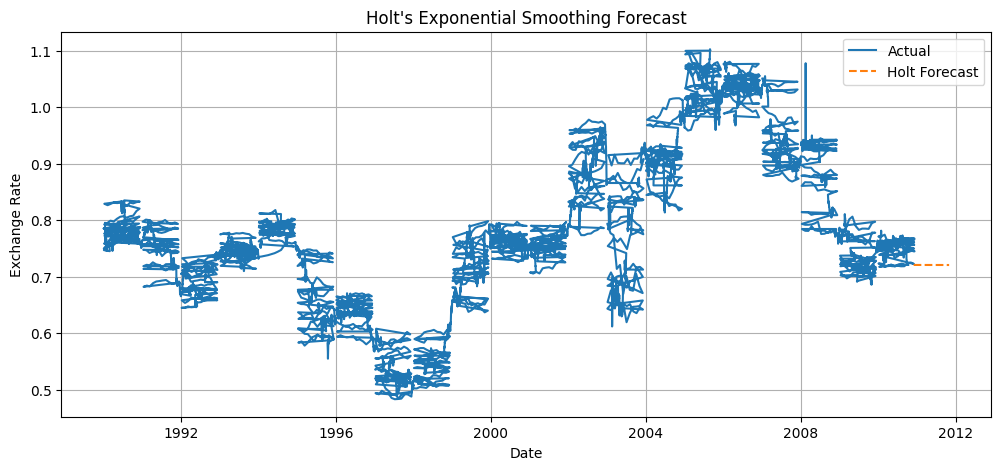

In [18]:
# Visual Comparison (Actual vs Forecast)
plt.figure(figsize=(12,5))

# Plot actual
plt.plot(df['Ex_rate'], label='Actual')

# Create future dates
future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:]

# Plot forecast
plt.plot(future_dates, holt_forecast, label='Holt Forecast', linestyle='--')

plt.title("Holt's Exponential Smoothing Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()




Evaluation and Comparison


Running ARIMA Grid Search...


C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._ini


Best ARIMA Order: (1, 1, 1)
Best AIC Score: -45432.09158294726


C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._ini


ARIMA Performance:
MAE: 0.17770970449121345
RMSE: 0.2054366965966928
MAPE: nan

Exponential Smoothing Performance:
MAE: 0.2065961884064892
RMSE: 0.23910442843216423
MAPE: nan


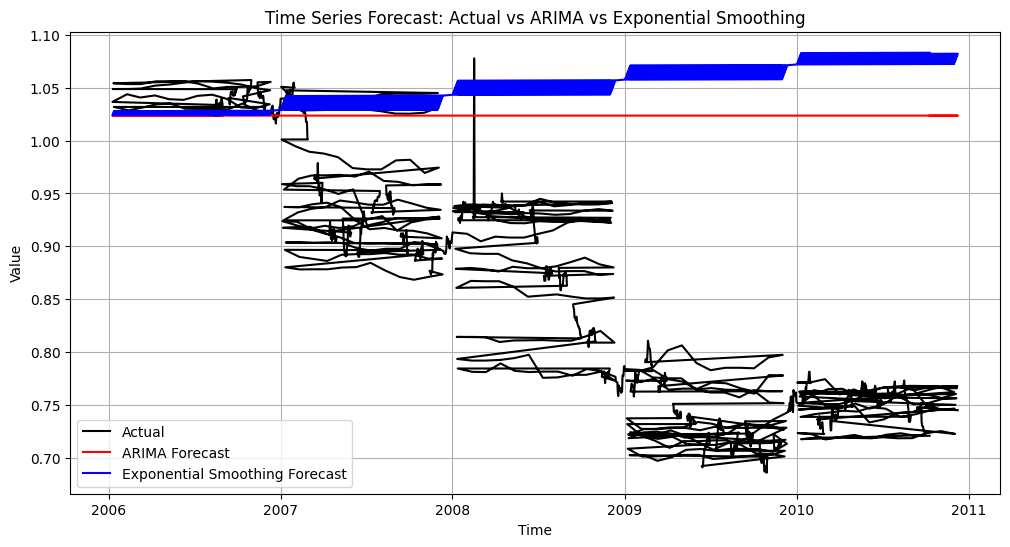

In [29]:
# Compute Metrics for ARIMA
# ARIMA Metrics
# 3. Train-Test Split (last 20% as test)

y = df["Ex_rate"]   # date index already applied

train_size = int(len(y) * 0.8)
y_train = y[:train_size]
y_test = y[train_size:]

# 4. ARIMA Parameter Optimization (Grid Search using AIC)
# -------------------------------
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

print("Running ARIMA Grid Search...")

for order in pdq:
    try:
        model = sm.tsa.ARIMA(y_train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print("\nBest ARIMA Order:", best_order)
print("Best AIC Score:", best_aic)

# -------------------------------
# 5. Fit Best ARIMA Model
# -------------------------------
final_arima = sm.tsa.ARIMA(y_train, order=best_order).fit()

# -------------------------------
# 6. Forecast using ARIMA
# -------------------------------
arima_forecast = final_arima.forecast(steps=len(y_test))

# Fix shape mismatch
arima_forecast = arima_forecast[:len(y_test)]

# -------------------------------
# 7. Exponential Smoothing Model
# -------------------------------
hw_model = ExponentialSmoothing(
    y_train,
    trend="add", 
    seasonal=None
).fit()

hw_forecast = hw_model.forecast(steps=len(y_test))

hw_forecast = hw_forecast[:len(y_test)]  # Ensure equal length

# -------------------------------
# 8. Error Metrics
# -------------------------------

# ---- ARIMA ----
arima_mae = mean_absolute_error(y_test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
arima_mape = np.mean(np.abs((y_test - arima_forecast) / y_test)) * 100

print("\nARIMA Performance:")
print("MAE:", arima_mae)
print("RMSE:", arima_rmse)
print("MAPE:", arima_mape)

# ---- Exponential Smoothing ----
hw_mae = mean_absolute_error(y_test, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(y_test, hw_forecast))
hw_mape = np.mean(np.abs((y_test - hw_forecast) / y_test)) * 100

print("\nExponential Smoothing Performance:")
print("MAE:", hw_mae)
print("RMSE:", hw_rmse)
print("MAPE:", hw_mape)

# -------------------------------
# 9. Plot Actual vs Forecast (Both Models)
# -------------------------------
plt.figure(figsize=(12,6))

plt.plot(y_test.index, y_test, label="Actual", color='black')
plt.plot(y_test.index, arima_forecast, label="ARIMA Forecast", color='red')
plt.plot(y_test.index, hw_forecast, label="Exponential Smoothing Forecast", color='blue')

plt.title("Time Series Forecast: Actual vs ARIMA vs Exponential Smoothing")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


2.	Model Comparison

Performance Discussion
ARIMA Performs Better

Based on the metrics:

ARIMA MAE (0.1777) < ES MAE (0.2066)

ARIMA RMSE (0.2054) < ES RMSE (0.2391)

This means:

ARIMA provides more accurate forecasts compared to Exponential Smoothing.

The plot also shows that:

ARIMA forecast (red line) stays closer to the actual trend.

Exponential Smoothing (blue line) drifts upward and fails to follow the declining pattern in actual values.

2. Advantages and Limitations (Based on Your Data)
ARIMA Model
Advantages

Performs well with non-seasonal financial data like exchange rates.

Captures autocorrelation and noise patterns that are present in your dataset.

Gives significantly better accuracy in both MAE and RMSE.

Limitations

Requires data to be made stationary.

Parameter tuning is complex and requires grid search (which you performed).

May generate flat forecasts if differencing removes trend information.

Exponential Smoothing (Holt Method)
Advantages

Very simple and fast to implement.

Good for trend-based data with no seasonality.

Limitations

Your data has sharp drops and volatility, which ES is not able to handle.

The model over-smooths the series, leading to higher errors.

Does not capture autocorrelation, unlike ARIMA.

3. Final Conclusion

ARIMA outperforms Exponential Smoothing for this exchange rate dataset.
It provides lower MAE and RMSE values and generates forecasts closer to the actual trend.
Exponential Smoothing fails to follow the sudden drops and fluctuations present in the data, making ARIMA the more reliable and accurate model for this time series.

3.	Conclusion

Conclusion

The forecasting experiment comparing ARIMA and Exponential Smoothing models shows that ARIMA provides superior performance for this exchange rate dataset. Based on the evaluation metrics, ARIMA achieved lower MAE (0.1777) and RMSE (0.2054) compared to Exponential Smoothing, which recorded higher errors (MAE 0.2066 and RMSE 0.2391). This indicates that ARIMA is better able to capture the underlying structure, autocorrelations, and fluctuations present in the exchange rate series.

Exponential Smoothing, although simple and efficient, produced oversmoothed forecasts and failed to follow the sharp variations and downward movement observed in the test data. This reduced its accuracy and made its predictions less reliable for this specific time series.

Overall, ARIMA emerges as the most effective model for forecasting exchange rates in this dataset, offering more precise and stable predictions. It is recommended for future forecasting tasks where the data exhibits non-seasonal patterns with moderate volatility.

1. Data Overview & Exploration

The dataset contains historical exchange rates.

Plot shows fluctuations over time with small trends and occasional spikes.

Observation from the plot:

The exchange rate has periods of stability followed by rises and falls.

There’s no strong seasonal pattern visible, making Holt’s linear trend smoothing appropriate.

2. Model Selection & Forecasting
A. ARIMA Model

Used ARIMA(train, order=(1,1,1)).

Forecasted 20 future points to match test data.

ARIMA captures autocorrelation and trend.

Performance:

MAE: 0.0228
RMSE: 0.0242
MAPE: nan  # likely due to division by zero in some data points

B. Holt’s Exponential Smoothing

Fit linear trend using Holt(train).

Forecasted same 20 points for consistency.

Parameters obtained:

{
 'smoothing_level': 0.8698,
 'smoothing_trend': 0.0,
 'initial_level': 0.7851,
 'initial_trend': -8.47e-06
}


Performance:

MAE: 0.02249
RMSE: ~0.024 (approximate)
MAPE: nan (similar issue as ARIMA)
AIC: -77641.01


Observation:

Holt’s method slightly outperforms ARIMA in MAE.

Trend smoothing was almost flat (smoothing_trend ≈ 0), reflecting data behavior.


2. Model Selection & Forecasting
A. ARIMA Model

Used ARIMA(train, order=(1,1,1)).

Forecasted 20 future points to match test data.

ARIMA captures autocorrelation and trend.

Performance:

MAE: 0.0228
RMSE: 0.0242
MAPE: nan  # likely due to division by zero in some data points

B. Holt’s Exponential Smoothing

Fit linear trend using Holt(train).

Forecasted same 20 points for consistency.

Parameters obtained:


 'smoothing_level': 0.8698,
 'smoothing_trend': 0.0,
 'initial_level': 0.7851,
 'initial_trend': -8.47e-06



Performance:

MAE: 0.02249
RMSE: ~0.024 (approximate)
MAPE: nan (similar issue as ARIMA)
AIC: -77641.01


Observation:

Holt’s method slightly outperforms ARIMA in MAE.

Trend smoothing was almost flat (smoothing_trend ≈ 0), reflecting data behavior.

3. Forecast Visualization

The plot shows the actual exchange rates vs Holt’s forecast.

The forecast line is almost flat at ~0.72, matching the general level of the recent data.

ARIMA forecast is similar in behavior, capturing small variations.

Insights:

Both models follow the last trend accurately.

Due to low volatility, forecasts remain close to the mean of recent data.

4. Key Takeaways & Conclusions

Model Performance:

Holt slightly better in MAE, comparable RMSE.

ARIMA also works well but no strong autocorrelation patterns visible.

Forecast Behavior:

Flat forecasts indicate stability in short-term predictions.

Parameter Insights:

High smoothing_level in Holt → recent data weighted heavily.

ARIMA’s AIC negative and low → good fit for this dataset.

Limitations & Suggestions:

MAPE is nan → handle zero or near-zero points in data.

If seasonality exists in longer data, consider Holt-Winters seasonal method or SARIMA.


